<a href="https://colab.research.google.com/github/du-hr/MNIST-CNN/blob/Teresa/MiniProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MiniProject 3: Multi-label Classification of Image Data


> MiniProject 3 of COMP 551 (Fall 2020) at McGill University


> Authors (G17): Haoran Du (260776911), Robin Cho (260806783), Teresa Lee (260715070)





In [144]:
import numpy as np
import scipy as sci
import pandas as pd
import h5py
import torch
from google.colab import drive
# ignore the follwoing line if running locally
drive.mount('/content/drive')
# make path = './' if running locally
path = '/content/drive/My Drive/'

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Datasets**

### **1.1 Import Data**

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>
(56000, 64, 64, 1)


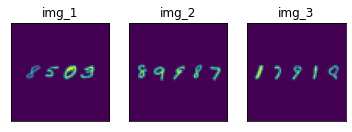

(56000, 5)
[[ 8  5  0  3 10]
 [ 8  9  9  8  7]
 [ 1  7  9  1  8]
 ...
 [ 4  4 10 10 10]
 [ 7  9  8 10 10]
 [ 6 10 10 10 10]]


In [145]:
# load the datasets
with h5py.File(path+'MNIST_synthetic.h5', 'r') as hdfid:
     print(hdfid.keys())
     test_images = hdfid['test_dataset'][()]
     train_images = hdfid['train_dataset'][()]
     train_labels = hdfid['train_labels'][()]

# display train_images properties
print(train_images.shape)
# print(train_iamges[10][30])

# plot first 3 images in train_images
images=[]
titles=[]
images.append(np.array(train_images[0], dtype='float').reshape(64,64))
titles.append("img_1")
images.append(np.array(train_images[1], dtype='float').reshape(64,64))
titles.append("img_2")
images.append(np.array(train_images[2], dtype='float').reshape(64,64))
titles.append("img_3")

for i in range(3):
    plt.subplot(1,3,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

# display train_labels properties
print(train_labels.shape)
print(train_labels)

### **1.2 Data Preprocessing**

###**1.2.1 One Hot Encoding**

In [ ]:
#First, perform OHE on training labels
from keras.utils import to_categorical

train_new_labels = to_categorical(train_labels)
Y_train = torch.from_numpy(train_new_labels) #save the oneHotEncoded labels as tensor

In [ ]:
Y_train

tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0.,

In [ ]:
Y_train.shape

### **1.2.2 Data Normalization**

In [ ]:
# normalize to range 0-1 with typecast to float
def data_scaled(x):
  scaled_x = x.astype('float32') / 255.0
  return scaled_x

scaled_train_images = data_scaled(train_images)
X_train = torch.from_numpy(scaled_train_images)

In [ ]:
X_train.shape

torch.Size([56000, 64, 64, 1])

###**1.2.3 Detecting the number of digits**

In [ ]:
import cv2
threshold = 1 #Hyperparameter?
width = 12
height = 12

In [ ]:
def findDigits(img):
  #Note that a normalized image does not work
  ret,thresh = cv2.threshold(img,threshold,255,0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  #print(len(contours))
  def getKey(item):
    return item[0]

  digitsLoc = []
  minArea = 15
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w == 1 and h > 4:
      listTemp = [x, y, w, h]
      digitsLoc.append(listTemp)
    
    elif w * h > minArea:
      listTemp = [x, y, w, h]
      digitsLoc.append(listTemp)
  
  return sorted(digitsLoc, key = lambda x: x[0])

In [ ]:
images_scaled=[]
images_scaled.append(np.array(train_images[4476], dtype='float').reshape(64,64))
sample = plt.imshow(images_scaled[0])
plt.show()

#x = findDigits(train_images[3282])
passed = 0
total = 0

for i in range(0, 56000):
  x = len(findDigits(train_images[i]))
  n = 0
  for c in train_labels[i]:
    if c != 10:
      n = n + 1
  
  if n == x:
    passed = passed + 1
  else:
    print("Case#: ",i, "Detected: " ,x, " Expected: ", n)
  total = total + 1

print(passed/total)

### **1.2.4 Class Distribution**


In [ ]:
unique_y1, counts_y1 = np.unique(train_labels[:, 0], return_counts=True)
plt.bar(unique_y1, counts_y1/sum(counts_y1))
plt.xticks(unique_y1, unique_y1)
plt.title(f"Class Distribution of the first column")
plt.show()

In [ ]:
unique_y2, counts_y2 = np.unique(train_labels[:, 1], return_counts=True)
plt.bar(unique_y2, counts_y2/sum(counts_y2))
plt.xticks(unique_y2, unique_y2)
plt.title(f"Class Distribution of the second column")
plt.show()

In [ ]:
unique_y3, counts_y3 = np.unique(train_labels[:, 2], return_counts=True)
plt.bar(unique_y3, counts_y3/sum(counts_y3))
plt.xticks(unique_y3, unique_y3)
plt.title(f"Class Distribution of the third column")
plt.show()

In [ ]:
unique_y4, counts_y4 = np.unique(train_labels[:, 3], return_counts=True)
plt.bar(unique_y4, counts_y4/sum(counts_y4))
plt.xticks(unique_y4, unique_y4)
plt.title(f"Class Distribution of the fourth column")
plt.show()

In [ ]:
unique_y5, counts_y5 = np.unique(train_labels[:, 4], return_counts=True)
plt.bar(unique_y5, counts_y5/sum(counts_y5))
plt.xticks(unique_y5, unique_y5)
plt.title(f"Class Distribution of the fifth column")
plt.show()

### **1.2.4 Calculate the bounds of the images**


In [ ]:
def lowerBound(x):
  N = x.shape[1]
  D = x.shape[0]
  lowerBounds = [0]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, j], bound)):
        lowerBounds[i] = j + 1
      else:
        break
  return min(lowerBounds)
  
def upperBound(x):
  N = x.shape[1]
  D = x.shape[0]
  upperBounds = [64]*D
  bound = x[0, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, 63-j], bound)):
        upperBounds[i] = 63-j
      else:
        break
  return max(upperBounds)

In [ ]:
def leftBound(x):
  N = x.shape[2]
  D = x.shape[0]
  leftBounds = [0]*D
  bound = x[0, :, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, :, j], bound)):
        leftBounds[i] = j + 1
      else:
        break
  return min(leftBounds)
  
def rightBound(x):
  N = x.shape[2]
  D = x.shape[0]
  rightBounds = [64]*D
  bound = x[0, :, 0]
  for i in list(range(0, D)):
    for j in list(range(0, N)):
      if torch.all(torch.eq(x[i, :, 63 - j], bound)):
        rightBounds[i] = 63 - j
      else:
        break
  return max(rightBounds)

In [ ]:
u = upperBound(X_train)
l = lowerBound(X_train)
l2 = leftBound(X_train)
r = rightBound(X_train)

print("Upper bound: ", u,", Lower bound:", l, ", Left bound: ", l2,", Right bound:", r)

### **1.2.5 Partitioning the data**


In [ ]:
def leftBound_digit(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.full(x[:, 0].shape, 0.2)
  for i in list(range(initial_column, N)):
    if torch.all(torch.le(x[:, i], bound)):
      leftBound = i + 1
    else:
      break
  return leftBound

In [ ]:
def rightBound_digit(x, initial_column):
  N = x.shape[1] #column
  leftBound = 0
  bound = torch.full(x[:, 0].shape, 0.2)
  for i in list(range(initial_column, N)):
    if torch.all(torch.le(x[:, i], bound)) == False:
      leftBound = i + 1
    else:
      break
  return leftBound

In [ ]:
def partition_image(x):
  x = x.reshape(64, 64)
  l = leftBound_digit(x, 0)
  r = rightBound_digit(x, l)
  x_1 = torch.zeros((12, 12))
  x_1[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]

  l = leftBound_digit(x, r)
  if l == 64: #i.e. one digit
    x_2 = torch.zeros((12, 12))
    x_3 = torch.zeros((12, 12))
    x_4 = torch.zeros((12, 12))
    x_5 = torch.zeros((12, 12))
  else:
    r = rightBound_digit(x, l)
    x_2 = torch.zeros((12, 12))
    x_2[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]

    l = leftBound_digit(x, r)

    if l == 64: #i.e. two digits
      x_3 = torch.zeros((12, 12))
      x_4 = torch.zeros((12, 12))
      x_5 = torch.zeros((12, 12))
    else:
      r = rightBound_digit(x, l)
      x_3 = torch.zeros((12, 12))
      x_3[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
      l = leftBound_digit(x, r)

      if l == 64: #i.e. three digits
        x_4 = torch.zeros((12, 12))
        x_5 = torch.zeros((12, 12))
      else:
        r = rightBound_digit(x, l)
        x_4 = torch.zeros((12, 12))
        x_4[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
        l = leftBound_digit(x, r)

        if l == 64:  #i.e. four digits
          x_5 = torch.zeros((12, 12))
        else: #i.e. five digits
          r = rightBound_digit(x, l)
          x_5 = torch.zeros((12, 12))
          x_5[0:12, 0: x[26:38,l:r].shape[1]] = x[26:38,l:r]
    
  x_0 = torch.stack((x_1, x_2, x_3, x_4, x_5))

  return x_0

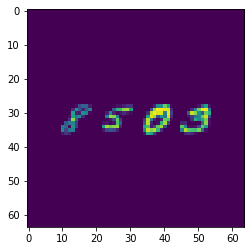

In [ ]:
x_try = X_train[0].reshape(64, 64)
plt.imshow(x_try)

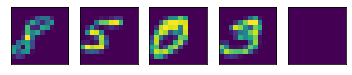

In [ ]:
x_try_part = partition_image(x_try)
for i in range(5):
    plt.subplot(1,5,i+1),plt.imshow(x_try_part[i, :, :])
    plt.xticks([]),plt.yticks([])

In [ ]:
#this code checks the accuracy per image
def partition_image_number_of_digits_accuracy(x):
  x = x.reshape(64, 64)
  l = leftBound_digit(x, 0)
  r = rightBound_digit(x, l)
  l = leftBound_digit(x, r)
  if l == 64: #i.e. one digit
    n = 1
  else:
    r = rightBound_digit(x, l)
    l = leftBound_digit(x, r)

    if l == 64: #i.e. two digits
      n = 2
    else:
      r = rightBound_digit(x, l)
      l = leftBound_digit(x, r)

      if l == 64: #i.e. three digits
        n = 3
      else:
        r = rightBound_digit(x, l)
        l = leftBound_digit(x, r)

        if l == 64:  #i.e. four digits
          n = 4
        else: #i.e. five digits
          r = rightBound_digit(x, l)
          n = 5
  return n

In [ ]:
def accuracy_check(x, y):
  D = x.shape[0]
  Y_true = torch.zeros(D)
  for i in list(range(0, D)):
    n = 0
    for c in y[i]:
      if c != 10:
        n = n + 1
    Y_true[i] = n

  correct = 0
  incorrect = 0
  for i in list(range(0, D)):
    if Y_true[i] == partition_image_number_of_digits_accuracy(x[i]):
      correct = correct + 1
    else:
      incorrect = incorrect +1
  return correct/(incorrect+correct)

In [ ]:
accuracy_check(X_train, train_labels)

0.997375

In [ ]:
#The accuracy is 0.994 when set threshold = 0
#The accuracy is 0.996 when set threshold = 0.25
#The accuracy is 0.986 when set threshold = 0.361

In [ ]:
def incorrect_list(x, y):
  D = x.shape[0]
  Y_true = torch.zeros(D)
  for i in list(range(0, D)):
    n = 0
    for c in y[i]:
      if c != 10:
        n = n + 1
    Y_true[i] = n

  correct = 0
  incorrect = []
  for i in list(range(0, D)):
    if Y_true[i] == partition_image_number_of_digits_accuracy(x[i]):
      correct = correct + 1
    else:
      incorrect.append(i)
  return incorrect

In [ ]:
incorrect_digits = incorrect_list(X_train, train_labels)

In [ ]:
correct_digits = list(range(0, X_train.shape[0]))
correct_digits = list(np.delete(np.array(correct_digits), (incorrect_digits), axis=0))

In [ ]:
accuracy_check(X_train[correct_digits, :], train_labels[correct_digits, :])

In [ ]:
def dataset_images_partition(x):
  d1 = x.shape[0]
  d2 = 5
  d3 = 12
  d4 = 12
  X_new = torch.zeros((d1, d2, d3, d4))
  for i in list(range(0, d1)):
    X_new[i] = partition_image(x[i])
  return X_new

In [ ]:
X_train_part = dataset_images_partition(X_train[correct_digits, :])
Y_train_part = Y_train[correct_digits, :]

In [146]:
Y_train_part = train_labels[correct_digits, :]

In [ ]:
X_train_part.shape

torch.Size([55853, 5, 12, 12])

### **1.2.6 Creating dataloader**

In [ ]:
def x_multiLabel_to_singleLabel(x):
  n = x.shape[0]
  n2 = x.shape[2]
  n3 = x.shape[3]
  new_x = torch.zeros((n*5, 1, n2, n3))
  for i in list(range(0, n)):
    for j in list(range(0, 5)):
      new_x[i*5+j] = x[i, j]
  return new_x

In [ ]:
X_train_part2 = x_multiLabel_to_singleLabel(X_train_part)

In [ ]:
X_train_part2.shape

torch.Size([279265, 1, 12, 12])

In [ ]:
Y_train.shape

torch.Size([56000, 5, 11])

In [ ]:
def y_multiLabel_to_singleLabel(y):
  n = y.shape[0]
  new_y = torch.zeros((n*5))
  for i in list(range(0, n)):
    for j in list(range(0, 5)):
      new_y[i*5+j] = y[i, j]
  return new_y

In [148]:
Y_train_part2 = y_multiLabel_to_singleLabel(Y_train_part)

In [149]:
Y_train_part2.shape

torch.Size([279265])

In [ ]:
def y_singleLabel_to_multiLabel(initial_x, new_y):
  n = initial_x.shape[0]
  y = torch.zeros((n, 5))
  for i in list(range(0, n)):
    for j in list(range(0, 5)):
      y[i, j] = new_y[i*5+j]
  return y

In [ ]:
from random import seed
from random import randint
seed(1)
# generate 6000 random integers for validation set
val_index = np.random.choice(55853*5, 6000*5, replace=False)
print(len(val_index))
train_index = np.setxor1d(np.arange(55853*5),val_index)
print(len(train_index))

30000
249265


In [173]:
from torch.utils.data import Dataset, DataLoader
class train_images_data(Dataset):
    def __init__(self):
      self.x = X_train_part2[train_index, :]
      self.y = Y_train_part2[train_index]
      self.n_samples = X_train_part2[train_index, :].shape[0]
    
    def __getitem__(self, index):
      return self.x[index], self.y[index]
    
    def __len__(self):
      return self.n_samples


train_data = train_images_data()
train_dataloader = DataLoader(dataset=train_data, batch_size = 36, shuffle = True)

In [ ]:
class val_images_data(Dataset):
    def __init__(self):
      self.x = X_train_part2[val_index, :]
      self.y = Y_train_part2[val_index]
      self.n_samples = X_train_part2[val_index, :].shape[0]
    
    def __getitem__(self, index):
      return self.x[index], self.y[index]
    
    def __len__(self):
      return self.n_samples


val_data = val_images_data()
val_dataloader = DataLoader(dataset=val_data, batch_size = 36, shuffle = True)

In [ ]:
len(val_data)

30000

In [ ]:
datatiter = iter(train_dataloader)
data = datatiter.next()
image, label = data

In [ ]:
image.shape

torch.Size([5, 5, 12, 12])

## **2. Neural Network Models**

In [150]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=18, kernel_size=3, stride=1, padding=1) # first convolution layer: 32*12*12
        self.conv_2 = torch.nn.Conv2d(in_channels=18, out_channels=36, kernel_size=3, stride=1, padding=1) # second convolution layer: 64*3*3
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2) 
        self.linear_1 = torch.nn.Linear(3 * 3 * 36, 72) # linear layer with 128 nodes
        self.linear_2 = torch.nn.Linear(72, 11) # match the output of 11 labels
        self.dropout = torch.nn.Dropout(p=0.5) # avoid overfitting between the two linear layers
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x) #32*6*6
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x) 
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

model2 = Model()

In [156]:
# GPU setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [157]:
model2.to(device)

Model(
  (conv_1): Conv2d(1, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=324, out_features=72, bias=True)
  (linear_2): Linear(in_features=72, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [175]:

# SGD optimizer with learning rate of 0.001
import torch.optim as optim
import torch.nn as nn

opts = {
    'lr': 1e-3,
    'epochs': 20,
    'batch_size': 36
}
optimizer = optim.Adam(model2.parameters(), opts['lr'])
#nn.CrossEntropyLoss()  # loss function

# maybe other optimizers?

In [176]:
# Train CNN for 20 epochs
no_epochs = 20
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    # unspervised training
    for i, (image, label) in enumerate(train_dataloader):
      pred = model2(image.cuda()) #dictionary to tensor
      label = label.to(device=device, dtype=torch.int64)
      loss = nn.functional.cross_entropy(pred, label)
      total_train_loss = total_train_loss + loss.item()
      
      loss.backward()
      optimizer.step()
      total_train_loss = total_train_loss / (i + 1)
      train_loss.append(total_train_loss)
    
    # validation
    model2.eval()
    total = 0
    
    for i, (image, label) in enumerate(val_dataloader):
      pred = model2(image.cuda())
      label = label.to(device=device, dtype=torch.int64)
      loss = nn.functional.cross_entropy(pred, label)
      total_val_loss = total_val_loss + loss.item()

      pred = torch.nn.functional.softmax(pred, dim=1)
      for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
          total = total + 1
          accuracy = total / len(val_data)
          total_val_loss = total_val_loss / (i + 1)
          val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model2.state_dict(), "model.dth")

RuntimeError: ignored

## **3. Performance**

In [ ]:
'''
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)
'''

In [ ]:
'''
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
'''

In [ ]:
'''
plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()
'''

## **4. Application to the Testing Images**

In [ ]:
scaled_test_images = data_scaled(test_images)
X_test = torch.from_numpy(scaled_test_images)
X_test_part = dataset_images_partition(X_test)

In [ ]:
X_test_part2 = x_multiLabel_to_singleLabel(X_test_part)

In [ ]:
X_test_part.shape

torch.Size([14000, 5, 12, 12])

In [ ]:
X_test_part2.shape

torch.Size([70000, 1, 12, 12])

In [ ]:
class test_images_data(Dataset):
    def __init__(self):
      self.x = X_test_part2
      self.n_samples = X_test_part2.shape[0]
    
    def __getitem__(self, index):
      return self.x[index]
    
    def __len__(self):
      return self.n_samples

test_data = train_images_data()
test_dataloader = DataLoader(dataset=test_data, batch_size = 36, shuffle = True)

In [ ]:
len(images)

2

In [ ]:
test_pred = []
for i, image in enumerate(test_dataloader):
   output = model2(image.cuda)
   _, predicted = torch.max(output.data, 1)
   test_pred.append(predicted)

AttributeError: ignored

In [ ]:
test_pred

tensor([[-0.0195,  0.2866,  0.5283, -0.4786,  0.4147,  0.1171,  0.4351,  0.6444,
         -0.4921, -0.1545, -2.5663]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
def y_singleLabel_to_multiLabel(initial_x, new_y):
  n = initial_x.shape[0]
  y = torch.zeros((n, 5))
  for i in list(range(0, n)):
    for j in list(range(0, 5)):
      y[i, j] = new_y[i*5+j]
  return y

In [ ]:
y_pred = y_singleLabel_to_multiLabel(X_test_part, test_pred)

In [ ]:

print(test_pred)

output = []
for i in range(len(test_pred)):
  string = str(test_pred[i][0])+str(test_pred[i][1])+str(test_pred[i][2])+str(test_pred[i][3])+str(test_pred[i][4])
  output.append(string)

print(output)

d = {'Id': np.arange(len(test_images)), 'Label': output}
df = pd.DataFrame(data=d)

from google.colab import files
df.to_csv('sample.csv',index=False) 
files.download('sample.csv')